## Predicting Pokemon Type Given Their Name with GLOVE

Link to the original Kaggle Notebook I created : https://www.kaggle.com/fabienroger/predicting-pokemon-type-given-their-name-w-glove

# Exploring the Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
df = pd.read_csv('/kaggle/input/pokemon/Pokemon.csv')
df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [3]:
df = df[['Name','Type 1']]

In [4]:
df.head()

,Name,Type 1
0,Bulbasaur,Grass
1,Ivysaur,Grass
2,Venusaur,Grass
3,VenusaurMega Venusaur,Grass
4,Charmander,Fire


In [5]:
import matplotlib.pyplot as plt

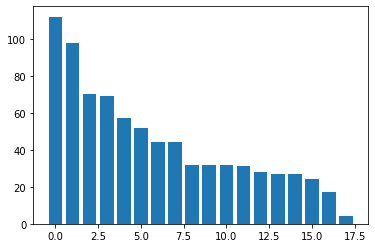

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ghost        32
Ground       32
Dark         31
Poison       28
Fighting     27
Steel        27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64

In [6]:
x = np.arange(len(df['Type 1'].unique()))
plt.bar(x, df['Type 1'].value_counts())
plt.show()

df['Type 1'].value_counts()

## Making Naïve Predictions

So if we only predicted "water", our accuracy would be : 

In [7]:
print(df['Type 1'].value_counts()[0]/df.shape[0])

0.14


I calculate TF.IDF

In [8]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

df['Name'] = df['Name'].apply(lambda s:s.lower())

def apparition(s,c):
    r = 0
    for x in s:
        if x==c: r+=1
    return r

apparitions = []
for i,c in enumerate(alphabet):
    df[str(i)] = df['Name'].apply(apparition, args=c)
    apparitions.append(sum(df[str(i)]))

letters = sum(apparitions)

for i,c in enumerate(alphabet):
    tf = df[str(i)]/df['Name'].apply(len)
    idf = letters/apparitions[i]
    df['tfidf'+str(i)] = tf*idf
df.head()

,Name,Type 1,0,1,2,3,4,5,6,7,...,tfidf16,tfidf17,tfidf18,tfidf19,tfidf20,tfidf21,tfidf22,tfidf23,tfidf24,tfidf25
0,bulbasaur,Grass,2,2,0,0,0,0,0,0,...,0.0,1.413975,2.166511,0.0,6.090114,0.000000,0.0,0.0,0.000000,0.0
1,ivysaur,Grass,1,0,0,0,0,0,0,0,...,0.0,1.817968,2.785514,0.0,3.915073,16.854722,0.0,0.0,8.084785,0.0
2,venusaur,Grass,1,0,0,0,1,0,0,0,...,0.0,1.590722,2.437325,0.0,6.851378,14.747881,0.0,0.0,0.000000,0.0
3,venusaurmega venusaur,Grass,3,0,0,0,3,0,1,0,...,0.0,1.211979,1.857009,0.0,5.220097,11.236481,0.0,0.0,0.000000,0.0
4,charmander,Fire,2,0,1,1,1,0,0,1,...,0.0,2.545155,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


Prediction using logistic regression

In [9]:
X = df[['tfidf'+str(i) for i,c in enumerate(alphabet)]]
y = df['Type 1']

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=1)

In [12]:
reg = LogisticRegression(max_iter = 10000, C=0.1)

In [13]:
reg.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=10000)

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
y_pred = reg.predict(X_val)
y_pred_train = reg.predict(X_train)
print(accuracy_score(y_pred_train,y_train))
print(accuracy_score(y_pred,y_val))

0.26875
0.16875


That's not much better than only gessing "water". Let's try to do something better by using a corpus of text, and it seems to be hard to reduce overfitting.

# Using GLOVE to make predictions using a LSTM trained to recognize synonyms of the types (Unsuccessful)

In [16]:
import re

In [17]:
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-100")
bests = glove.most_similar("fire", topn= 5)
print(bests)

[==================================================] 100.0% 128.1/128.1MB downloaded
[('fires', 0.7522280812263489), ('fired', 0.7405155897140503), ('firing', 0.7302654385566711), ('attack', 0.7193385362625122), ('explosion', 0.7003915309906006)]


In [18]:

bests = glove.most_similar("fire", topn= 5)
print(' '.join([str(x[0])+' '+str(x[1])+'\n' for x in bests]))

fires 0.7522280812263489
 fired 0.7405155897140503
 firing 0.7302654385566711
 attack 0.7193385362625122
 explosion 0.7003915309906006



In [19]:
bests = glove.most_similar("flying", topn= 500)
print(' '.join([str(x[0]) for x in bests]))

flew fly planes jet aircraft plane flight airplane airplanes air helicopter flown fighter landing crashed flies aboard pilot jets flights carrying helicopters pilots landed reconnaissance ground traveling carrier aerial flag spotted train airlines off moving airliner cargo crash ship c-130 force missions crew craft piloting squadron hawk training carried eagle balloon collided boat sky airliners overhead combat returning b-17 passenger bound light ships travelling aviation squadrons down out jetliner away airline taking went passengers piloted wings grounded sailing fleet hijacked red f-16 dropping gliding when bombers navy small boats crashing chopper arriving 747 sending boarding glider seen stopped space chartered radar travel circled heading flags weather altitude crews sea operated shuttle airport sail taken cruise heavy boeing coming arrived climbing day tactical approaching leaving around driving airborne warplanes up vessel fog patrol boarded trip crashes kite back night turned

In [20]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input

In [21]:
vocab_size = 27
pk_types = len(df['Type 1'].unique())
max_name_length = df['Name'].map(len).max()

In [22]:
import tensorflow as tf

In [23]:
'''tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():'''
inputs = Input(shape=(max_name_length,vocab_size))
X = LSTM(32, return_sequences=True, recurrent_dropout = 0.3 , dropout = 0.3)(inputs)
X = LSTM(32, recurrent_dropout = 0.2 , dropout = 0.2)(X)
X = Dense(pk_types, activation='softmax')(X)
model = Model(inputs=inputs, outputs=X)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])

In [24]:
types = list(df['Type 1'].unique())
print(types)

['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric', 'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice', 'Dragon', 'Dark', 'Steel', 'Flying']


In [25]:
alphabet = '#abcdefghijklmnopqrstuvwxyz'

In [26]:
def clean(s):
    return re.sub(r'[^a-z]','', s.lower())

def left_pad_and_clean(s):
    s = clean(s)
    if len(s)>=max_name_length:
        return s[:max_name_length]
    else:
        while len(s)<max_name_length:
            s = '#'+s
        return s

In [27]:
print(left_pad_and_clean('  heyé--'))
print(clean('dej JF,'))

######################hey
dejjf


In [28]:
def str_to_vec(s):
    s = left_pad_and_clean(s)
    vec = np.zeros(shape=(max_name_length,vocab_size))
    for i,c in enumerate(s):
        if c not in alphabet:print(c)
        vec[i,alphabet.index(c)] = 1
    return vec

In [29]:
str_to_vec('azerty').shape

(25, 27)

In [30]:
n = 500
#subtask_df = pd.DataFrame(columns=['X','y'])
N = n*len(types)
stX = np.zeros(shape=(N,max_name_length,vocab_size))
stXweight = np.zeros(shape=(N,1))
sty = np.zeros(shape=(N,len(types)))
act_i = 0
for j,t in enumerate(types):
    ms = glove.most_similar(clean(t), topn=n-1)
    close_words = [clean(str(x[0])) for x in ms]
    close_words_w = [x[1] for x in ms]
    close_words.append(clean(t))
    close_words_w.append(1)
    for i,w in enumerate(close_words):
        vec = str_to_vec(w)
        stX[act_i,:,:] = vec
        stXweight[act_i,0] = close_words_w[i]
        sty[act_i,j] = 1
        act_i += 1
        
        #subtask_df = subtask_df.append({'X': str_to_vec(w),'y':str_to_vec(cleant)}, ignore_index=True)
    


In [31]:
print(stX.shape, sty.shape)

(9000, 25, 27) (9000, 18)


In [32]:
from sklearn.model_selection import train_test_split
stX_train, stX_val,stXweight_train,stXweight_val, sty_train, sty_val =\
    train_test_split(stX, stXweight,sty,shuffle=True,\
                     test_size=0.1, random_state=1)

In [33]:
model.fit(stX_train, sty_train,sample_weight=stXweight_train,batch_size=128,\
          epochs=20, validation_data = (stX_val, sty_val,stXweight_val),verbose=1)

Epoch 1/20
64/64 [==============================] - 12s 183ms/step - loss: 1.3733 - accuracy: 0.0554 - val_loss: 1.3712 - val_accuracy: 0.0533
Epoch 2/20
64/64 [==============================] - 11s 170ms/step - loss: 1.3674 - accuracy: 0.0599 - val_loss: 1.3654 - val_accuracy: 0.0667
Epoch 3/20
64/64 [==============================] - 18s 283ms/step - loss: 1.3579 - accuracy: 0.0807 - val_loss: 1.3554 - val_accuracy: 0.0956
Epoch 4/20
64/64 [==============================] - 12s 194ms/step - loss: 1.3552 - accuracy: 0.0819 - val_loss: 1.3521 - val_accuracy: 0.0911
Epoch 5/20
64/64 [==============================] - 12s 191ms/step - loss: 1.3518 - accuracy: 0.0858 - val_loss: 1.3534 - val_accuracy: 0.0978
Epoch 6/20
64/64 [==============================] - 11s 174ms/step - loss: 1.3491 - accuracy: 0.0865 - val_loss: 1.3507 - val_accuracy: 0.0878
Epoch 7/20
64/64 [==============================] - 12s 186ms/step - loss: 1.3479 - accuracy: 0.0867 - val_loss: 1.3510 - val_accuracy: 0.0900

In [34]:
r = model.evaluate(stX_val, sty_val,sample_weight=stXweight_val)
print(r[1])
r = model.evaluate(stX_train, sty_train,sample_weight=stXweight_train)
print(r[1])

29/29 [==============================] - 0s 12ms/step - loss: 1.3422 - accuracy: 0.1011
0.10111111402511597
254/254 [==============================] - 3s 12ms/step - loss: 1.3181 - accuracy: 0.1177
0.11765432357788086


A lot of overfitting, but this might not be a problem. I want the model to "remember" the words associated with water. But I still want the model to generalize to imaginary words close to the original concept. Let's see if that's the case.

## Direct prediction

In [35]:
N = df.shape[0]
diX = np.zeros(shape=(N,max_name_length,vocab_size))
diy = np.zeros(shape=(N,len(types)))
for index, row in df.iterrows():
    diX[index,:,:] = str_to_vec(row['Name'])
    diy[index,types.index(row['Type 1'])] = 1

In [36]:
print(diX.shape)
r = model.evaluate(diX, diy)
print(r[1])

(800, 25, 27)
25/25 [==============================] - 1s 20ms/step - loss: 3.0265 - accuracy: 0.0550
0.054999999701976776


Wut :'(

In [37]:
ypred = model.predict(diX)
ypred_words = model.predict(stX_val)

(array([ 12.,  31.,  94.,  59., 154., 271.,  25.,  14.,  42.,  98.]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ]),
 <a list of 10 Patch objects>)

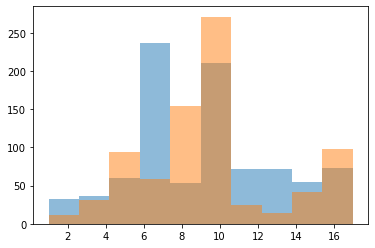

In [38]:
def amax(array):
    return array.argmax()

b = np.apply_along_axis(amax, 1, ypred_words)
plt.hist(b, alpha = 0.5)
a = np.apply_along_axis(amax, 1, ypred)
plt.hist(a, alpha = 0.5)

Pokemons have only psychic names...

## Indirect Prediction

I fit pokemon names to the predicted types

In [39]:
X_of_predictor = model.predict(diX)
y_of_predictor = np.apply_along_axis(lambda a:a.argmax(), 1, diy)

(array([ 70.,  52., 112.,  69.,  98.,  28.,  44.,  32.,  17.,  27.,  57.,
         44.,  32.,  24.,  32.,  31.,  27.,   4.]),
 array([ 0.        ,  0.94444444,  1.88888889,  2.83333333,  3.77777778,
         4.72222222,  5.66666667,  6.61111111,  7.55555556,  8.5       ,
         9.44444444, 10.38888889, 11.33333333, 12.27777778, 13.22222222,
        14.16666667, 15.11111111, 16.05555556, 17.        ]),
 <a list of 18 Patch objects>)

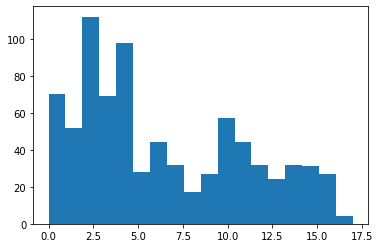

In [40]:
plt.hist(y_of_predictor, bins = len(types))

In [41]:
idiX_train, idiX_val, idiy_train, idiy_val =\
    train_test_split(X_of_predictor,y_of_predictor,test_size = 0.33,\
                     shuffle=True, random_state=1)

In [42]:
predictor = LogisticRegression()

In [43]:
predictor.fit(idiX_train, idiy_train)

LogisticRegression()

In [44]:
ypred = predictor.predict(idiX_val)

In [45]:
idiy_val

array([ 1,  0,  4,  1,  2,  6, 16, 10,  1,  2,  9,  0,  3,  2, 17,  0,  1,
        4, 16,  2,  2, 10,  6,  1,  7,  5, 10,  2,  0,  5, 16, 13,  3,  1,
       11,  9,  2, 13,  1, 15, 13, 16,  5,  2,  2,  4, 10,  7, 13,  6,  1,
       10, 12,  0,  0,  2,  2,  6,  2,  2, 14,  6, 12,  6, 15,  6,  2,  0,
       14,  4,  4, 13,  3,  4, 12,  7, 10,  2, 11,  0, 11,  3, 15, 14,  1,
        1, 10, 13,  7, 12,  0,  8,  9, 12,  4, 10, 10,  8,  0,  3,  4,  1,
       10,  3, 10,  2, 14,  6,  4,  2,  0,  6,  0, 11,  0,  0, 11,  5,  7,
        0, 13,  2, 12,  4,  7,  0,  5, 13,  3,  9, 16,  2,  4, 16, 10,  4,
        6,  1, 10,  0,  4, 12,  2,  3,  7, 16,  9, 14,  3, 15,  5,  4, 16,
       14,  8,  7,  3,  2,  9,  6, 10, 16,  0,  4,  0,  9, 10,  1,  2, 13,
        0,  0,  0,  3, 14,  2, 14,  0, 14,  2, 12,  6, 12,  3,  6,  2,  4,
        4,  4,  2,  9,  3,  6,  5, 17, 12, 15,  4,  8,  2,  3,  2,  4, 10,
       10,  0, 14,  8,  6, 16, 14, 10,  0,  3,  4, 10,  2,  2,  0,  5,  6,
        6,  8,  4,  2,  5

In [46]:
ypred

array([2, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 2, 2, 4, 2, 4, 4, 4, 2, 4, 2, 4, 2, 4, 4, 2, 2, 4, 4, 4, 4, 4,
       2, 4, 4, 4, 2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 2, 4, 4, 4, 4,
       4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 4,
       4, 2, 4, 4, 2, 2, 2, 4, 2, 4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 4, 4, 4,
       2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 2, 2,
       4, 4, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2,
       4, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 2, 2, 2, 4, 4, 4, 2, 2, 4,
       4, 4, 4, 2, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 2, 2, 4, 4, 2, 2, 4, 4,
       4, 2, 4, 2, 4, 2, 2, 2, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4,
       4, 2, 4, 2, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 2, 2, 4, 2, 2,
       4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4])

(array([[  0.,   0., 105.,   0., 159.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 27.,  17.,  38.,  19.,  24.,  10.,  19.,   9.,   8.,   9.,  22.,
          10.,  13.,   9.,  12.,   5.,  11.,   2.]]),
 array([ 0.        ,  0.94444444,  1.88888889,  2.83333333,  3.77777778,
         4.72222222,  5.66666667,  6.61111111,  7.55555556,  8.5       ,
         9.44444444, 10.38888889, 11.33333333, 12.27777778, 13.22222222,
        14.16666667, 15.11111111, 16.05555556, 17.        ]),
 <a list of 2 Lists of Patches objects>)

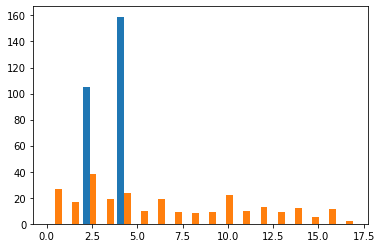

In [47]:
#ypred_classes = np.apply_along_axis(lambda a:a.argmax(), 1, ypred)
#plt.hist(ypred,alpha=0.5)
plt.hist([ypred,idiy_val], bins=len(types))

In [48]:
from sklearn.metrics import accuracy_score

In [49]:
print(accuracy_score(ypred, idiy_val))

0.11363636363636363


worse than random :'(((((

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


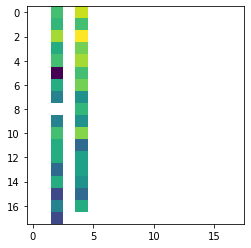

In [50]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(idiy_val, ypred)
plt.imshow(np.log(cm))

# Using GLOVE to make predictions by counting the number of subwords of synonyms of the types inside Pokemon names

I try using the well-know fact that fire-related word are used in the name of a pokemon (for example "Typhlosion" contains a part of "explosion", which is in the set of words close too "fire"). So I look for matches.

In [51]:
# For which values of k a k-uplet will be looked for in the pokemon name
char_range = [4,5,6,7] 

## Preprocessing

In [52]:
scores = np.zeros(shape=(df.shape[0], len(types)*len(char_range)))

name_s = {}

for index, row in df.iterrows():
    name = clean(row['Name'])
    
    for k in char_range:
        for i in range(len(name)-k):
            sub_name = name[i:i+k]
            if sub_name not in name_s:
                name_s[sub_name] = []
            name_s[sub_name].append(index)
    
for j,t in enumerate(types):
    ms = glove.most_similar(clean(t), topn=n-1)
    close_words = [(clean(str(x[0])),x[1]) for x in ms]
    close_words.append((clean(t),1))

    for ind,k in enumerate(char_range):
        for w,s in close_words:
            for i in range(len(w)-k):
                sub_word = w[i:i+k]
                if sub_word in name_s:
                    pokemons_containing_sw = name_s[sub_word]
                    for index in pokemons_containing_sw:
                        scores[index,j*len(char_range)+ind] += s
            


    

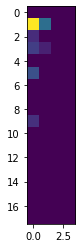

In [53]:

plt.imshow(scores[171,:].reshape((len(types),len(char_range))))

In [54]:
def inv_avg(x):
    return 0 if x.mean() == 0 else 1/x.mean()
inverse_averages = np.apply_along_axis(inv_avg, 0, scores)

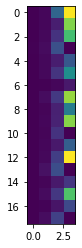

In [55]:
plt.imshow(inverse_averages.reshape((len(types),len(char_range))))

## Fitting a simple model

In [56]:
freqX = inverse_averages*scores
freqy = y_of_predictor
names = list(df['Name'])

freqX_train, freqX_val, freqy_train, freqy_val, names_train, names_val =\
    train_test_split(freqX,freqy,names,test_size = 0.33,\
                     shuffle=True, random_state=1)

In [57]:
freq_reg = LogisticRegression(max_iter = 10000)

In [58]:
freq_reg.fit(freqX_train, freqy_train)

LogisticRegression(max_iter=10000)

In [59]:
print(accuracy_score(freqy_val, freq_reg.predict(freqX_val)))

0.1856060606060606


## Finding the best model and hyperparameters

In [60]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [61]:
freq_models = [LogisticRegression(C = 1, max_iter = 10000), 
               LogisticRegression(C = 100, max_iter = 10000), 
               SVC(), 
               SVC(kernel='linear'), 
               DecisionTreeClassifier(max_depth=6)]

for m in freq_models:
    m.fit(freqX_train, freqy_train)
    print(accuracy_score(freqy_val, m.predict(freqX_val)))

0.1856060606060606
0.1893939393939394
0.10984848484848485
0.1856060606060606
0.11363636363636363


In [62]:
for p in [0.5,1,2,3,4]:
    print('using p =',p)
    for n in [200,250,300,350,400]:
        print('using n =',n)

        scores = np.zeros(shape=(df.shape[0], len(types)*len(char_range)))

        name_s = {}

        for index, row in df.iterrows():
            name = clean(row['Name'])

            for k in char_range:
                for i in range(len(name)-k):
                    sub_name = name[i:i+k]
                    if sub_name not in name_s:
                        name_s[sub_name] = []
                    name_s[sub_name].append(index)

        for j,t in enumerate(types):
            ms = glove.most_similar(clean(t), topn=n-1)
            close_words = [(clean(str(x[0])),x[1]) for x in ms]
            close_words.append((clean(t),1))

            for ind,k in enumerate(char_range):
                for w,s in close_words:
                    for i in range(len(w)-k):
                        sub_word = w[i:i+k]
                        if sub_word in name_s:
                            pokemons_containing_sw = name_s[sub_word]
                            for index in pokemons_containing_sw:
                                scores[index,j*len(char_range)+ind] += s**p

        inverse_averages = np.apply_along_axis(inv_avg, 0, scores)

        freqX = inverse_averages*scores
        freqy = y_of_predictor
        names = list(df['Name'])

        freqX_train, freqX_val, freqy_train, freqy_val, names_train, names_val =\
            train_test_split(freqX,freqy,names,test_size = 0.33,\
                             shuffle=True, random_state=1)

        freq_model = LogisticRegression(penalty='none', max_iter = 10000)

        freq_model.fit(freqX_train, freqy_train)
        print(accuracy_score(freqy_val, freq_model.predict(freqX_val)))

using p = 0.5
using n = 200
0.18181818181818182
using n = 250
0.19318181818181818
using n = 300
0.2159090909090909
using n = 350
0.18181818181818182
using n = 400
0.18181818181818182
using p = 1
using n = 200
0.1856060606060606
using n = 250
0.19318181818181818
using n = 300
0.21212121212121213
using n = 350
0.1856060606060606
using n = 400
0.1856060606060606
using p = 2
using n = 200
0.1856060606060606
using n = 250
0.1856060606060606
using n = 300
0.2196969696969697
using n = 350
0.20075757575757575
using n = 400
0.1856060606060606
using p = 3
using n = 200
0.1856060606060606
using n = 250
0.19696969696969696
using n = 300
0.21212121212121213
using n = 350
0.20833333333333334
using n = 400
0.19696969696969696
using p = 4
using n = 200
0.1893939393939394
using n = 250
0.19696969696969696
using n = 300
0.20075757575757575
using n = 350
0.20833333333333334
using n = 400
0.20454545454545456


Fitting the best model

In [63]:
n = 300

scores = np.zeros(shape=(df.shape[0], len(types)*len(char_range)))

name_s = {}

for index, row in df.iterrows():
    name = clean(row['Name'])

    for k in char_range:
        for i in range(len(name)-k):
            sub_name = name[i:i+k]
            if sub_name not in name_s:
                name_s[sub_name] = []
            name_s[sub_name].append(index)

for j,t in enumerate(types):
    ms = glove.most_similar(clean(t), topn=n-1)
    close_words = [(clean(str(x[0])),x[1]) for x in ms]
    close_words.append((clean(t),1))

    for ind,k in enumerate(char_range):
        for w,s in close_words:
            for i in range(len(w)-k):
                sub_word = w[i:i+k]
                if sub_word in name_s:
                    pokemons_containing_sw = name_s[sub_word]
                    for index in pokemons_containing_sw:
                        scores[index,j*len(char_range)+ind] += s**2

inverse_averages = np.apply_along_axis(inv_avg, 0, scores)

freqX = inverse_averages*scores
freqy = y_of_predictor
names = list(df['Name'])

freqX_train, freqX_val, freqy_train, freqy_val, names_train, names_val =\
    train_test_split(freqX,freqy,names,test_size = 0.33,\
                     shuffle=True, random_state=1)

freq_model = LogisticRegression(penalty='none', max_iter = 10000)

freq_model.fit(freqX_train, freqy_train)
print('Accuracy : ',accuracy_score(freqy_val, freq_model.predict(freqX_val)))

Accuracy :  0.2196969696969697


So our best guess accuracy can be achieved using this method, and is arround 22%.

## Error Analysis

In [64]:
print('Accuracy over the training set :', accuracy_score(freqy_train, freq_model.predict(freqX_train)))

Accuracy over the training set : 0.39552238805970147


There is quite a lot of overfitting, but all my attempts at reducing it only resulted in less accuracy on the validation set.

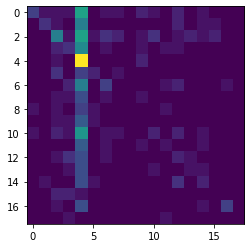

In [65]:
preds = freq_model.predict(freqX_val)
cm = confusion_matrix(freqy_val, preds)
plt.imshow(cm)

['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric', 'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice', 'Dragon', 'Dark', 'Steel', 'Flying']


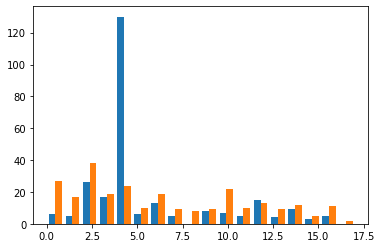

In [66]:
plt.hist([preds, freqy_val], bins=len(types))
print(types)

It seems to love the type "Normal".

# Final prediction on the validation set

The prediction made by the algorithm :

In [67]:
pred_df = pd.DataFrame(columns=['Name', 'Predicted type', 'Actual type'])

for i,x in enumerate(preds):
    name = names_val[i]
    pred_df = pred_df.append({'Name':name,
                              'Predicted type':types[x],
                              'Actual type': types[freqy_val[i]]}, ignore_index = True)

pd.set_option('display.max_rows', None)
print(pred_df)

                          Name Predicted type Actual type
0    charizardmega charizard y           Fire        Fire
1                    abomasnow         Normal       Grass
2                      sentret         Normal      Normal
3                       litleo          Water        Fire
4                    octillery        Psychic       Water
5                   helioptile       Electric    Electric
6                       dialga         Normal       Steel
7          deoxysdefense forme         Dragon     Psychic
8                     rapidash         Normal        Fire
9                       swanna         Normal       Water
10                     tyrogue         Normal    Fighting
11                   exeggutor         Normal       Grass
12                     silcoon         Normal         Bug
13       sharpedomega sharpedo           Dark       Water
14       tornadustherian forme            Bug      Flying
15                     leafeon          Grass       Grass
16            